In [1]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'
# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'   # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))




In [2]:
# Group by 'specie' and 'Cluster_Label' and count the number of elements
grouped_data = data.groupby(['species', 'Cluster_Label']).size().reset_index(name='count')

species_clusters = data.groupby(['species', 'Cluster_Label']).size().unstack()
species_clusters.columns = [f'cluster_{i}' for i in species_clusters.columns]
species_clusters.fillna(0, inplace=True)

print(species_clusters)

                    cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
species                                                                     
ABULON                    0.0       12.0        0.0       20.0        0.0   
ALGAS                     0.0       39.0        0.0       38.0        0.0   
ALMEJA                   44.0     5285.0       25.0     2654.0       25.0   
ANCHOVETA                 0.0        3.0        0.0        2.0        0.0   
ATUN                      0.0        7.0        0.0      273.0        0.0   
BANDERA                  58.0     1065.0        1.0     7560.0       13.0   
BAQUETA                   0.0     6408.0       35.0     4768.0       19.0   
BARRILETE                 0.0       18.0        0.0      120.0        0.0   
BERRUGATA                16.0     4728.0        6.0     8935.0       19.0   
BESUGO                    0.0        0.0        0.0        1.0        0.0   
BONITO                    0.0       39.0        0.0       49.0        1.0   

C:\Users\ricar\AppData\Local\Temp\ipykernel_10960\3844377045.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(5, 'r')).reset_index(drop=True)
C:\Users\ricar\AppData\Local\Temp\ipykernel_10960\3844377045.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models_per_cluster = performance_df.groupby('cluster').apply(lam

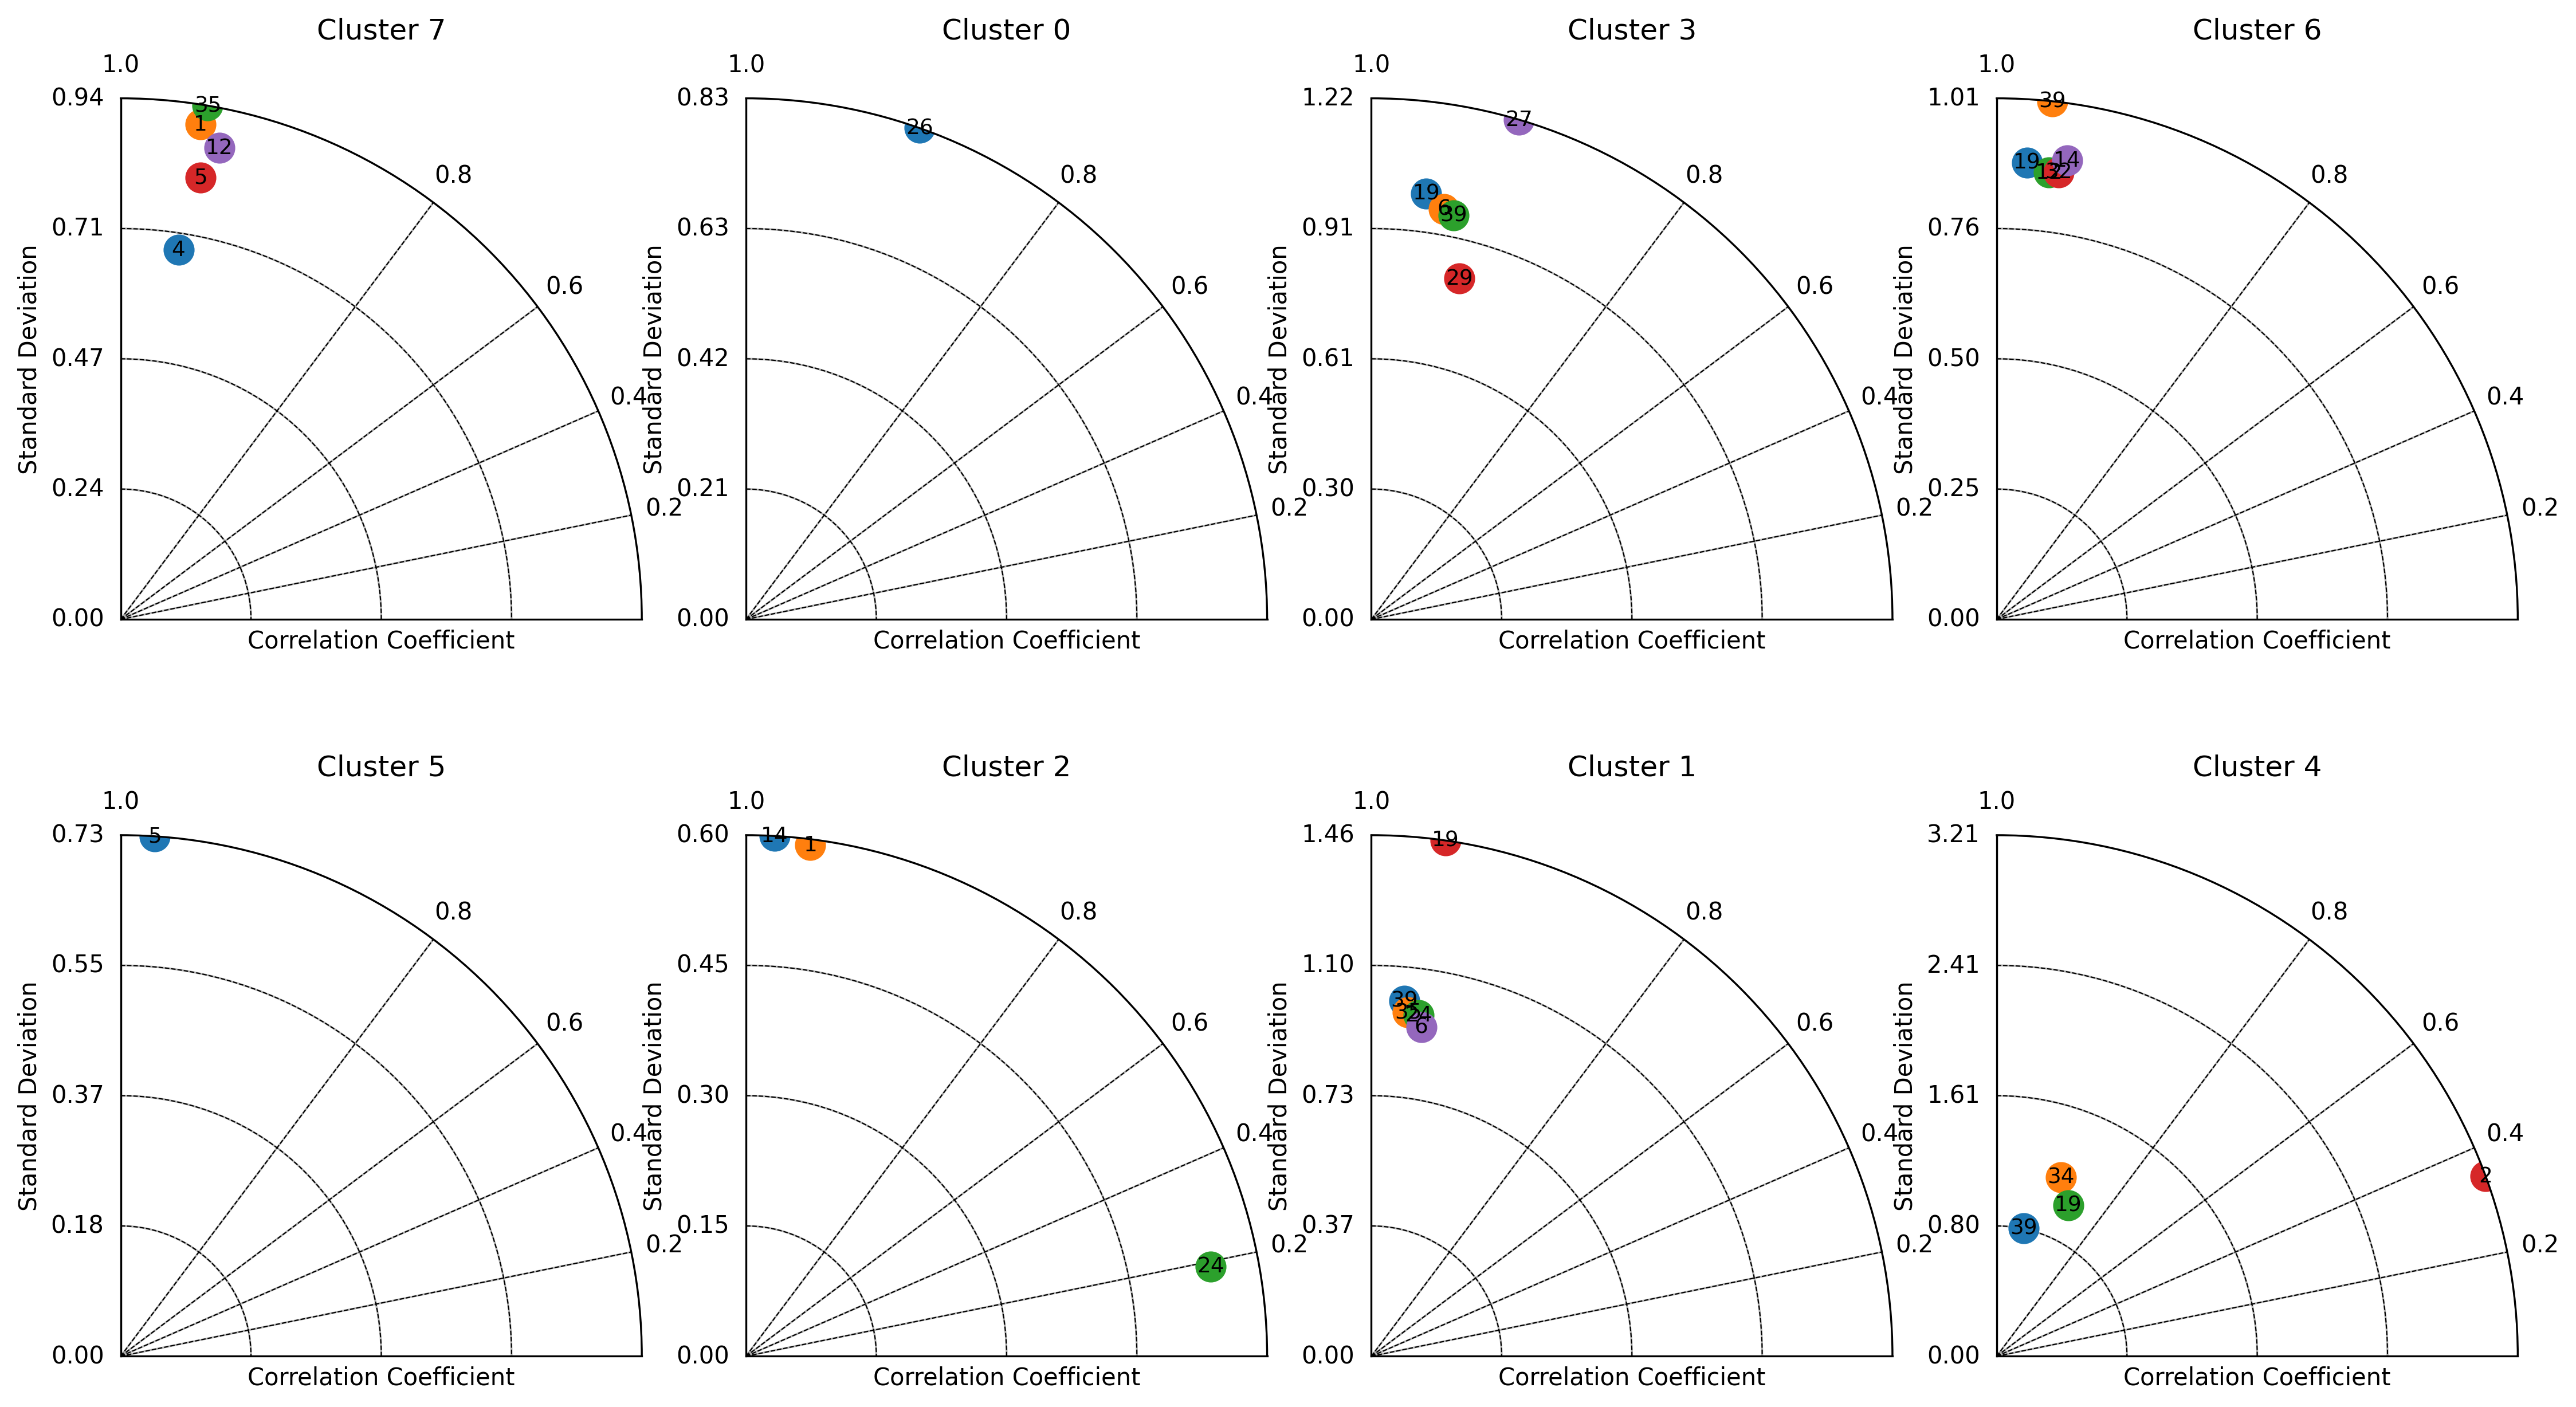

Mejores modelos por clúster:
             species  cluster    stddev         r
0             ALMEJA        0  0.834650  0.942965
1            CAMARON        1  1.001678  0.995765
2   RAYA Y SIMILARES        1  0.970023  0.994364
3             LOBINA        1  0.965775  0.990413
4            BAQUETA        2  0.601602  0.998510
5            MOJARRA        2  0.594663  0.992158
6             LOBINA        2  0.546408  0.189802
7              JAIBA        3  1.003262  0.991804
8            TIBURON        3  0.973352  0.984779
9            CAMARON        3  0.963451  0.979895
10           CAMARON        4  0.806751  0.978211
11           SARDINA        4  1.170945  0.940951
12             JAIBA        4  1.028822  0.903816
13            SIERRA        5  0.730926  0.997895
14             JAIBA        6  0.886921  0.997817
15           CAMARON        6  1.009985  0.994230
16         BERRUGATA        6  0.872201  0.993207
17             PARGO        7  0.675340  0.988006
18           MOJARRA 

In [3]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar una lista para almacenar los valores de rendimiento
performance_data = []

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r y stddev
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                
                # Manejar casos donde la desviación estándar es 0 para evitar divisiones por 0
                if std_obs > 0 and std_pred > 0:
                    corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                else:
                    corr = np.nan  # Si no se puede calcular, asignar NaN

                # Agregar solo si no hay NaN
                if not np.isnan(corr):
                    performance_data.append({
                        'species': species_name,
                        'cluster': cluster_label,
                        'stddev': std_pred / std_obs,
                        'r': corr
                    })

# Convertir la lista en un DataFrame
performance_df = pd.DataFrame(performance_data)

# Seleccionar los top 5 modelos para cada clúster
top_5_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(5, 'r')).reset_index(drop=True)

# Identificar el mejor modelo para cada clúster
best_models_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'r')).reset_index(drop=True)

# Parámetros de tamaño de figura y DPI
fig_size = (15, 10)  # Puedes modificar estas dimensiones
fig_dpi = 300  # Puedes modificar la resolución

# Crear la figura para todos los subplots
fig, axes = plt.subplots(2, 4, figsize=fig_size, subplot_kw={'polar': True}, dpi=fig_dpi)
axes = axes.flatten()

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_numbers, title, marker_size=10):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi/2, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo con tamaño de marcador más grande
    for i, (std, t) in enumerate(zip(stddev, theta)):
        ax.plot(t, std, 'o', label=f'Species {species_numbers[i]}', markersize=marker_size)  # Tamaño del marcador parametrizado
        ax.text(t, std, str(species_numbers[i]), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(90)  # Mostrar solo un cuarto de la circunferencia
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.set_title(title)
    ax.grid(True)
    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Iterar sobre cada clúster para crear el diagrama de Taylor
for ax, cluster_label in zip(axes, unique_clusters):
    cluster_data = top_5_per_cluster[top_5_per_cluster['cluster'] == cluster_label]
    if not cluster_data.empty:
        stddev = cluster_data['stddev'].tolist()
        corrcoef = cluster_data['r'].tolist()
        species_numbers = [species_to_num[species] for species in cluster_data['species']]
        
        # Crear el diagrama de Taylor para el clúster actual
        if len(stddev) > 0 and len(corrcoef) > 0:
            taylor_diagram(ax, stddev, corrcoef, species_numbers, title=f'Cluster {cluster_label}', marker_size=12)

# Crear una única leyenda con nombres de especies y sus números
species_labels = [f'{num}: {species}' for species, num in species_to_num.items()]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=12, label=label) for label in species_labels]  # Aumentar tamaño del marcador

# Añadir títulos y etiquetas a los ejes
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.25)
plt.show()

# Imprimir la lista de los mejores modelos por clúster
print("Mejores modelos por clúster:")
print(best_models_per_cluster)



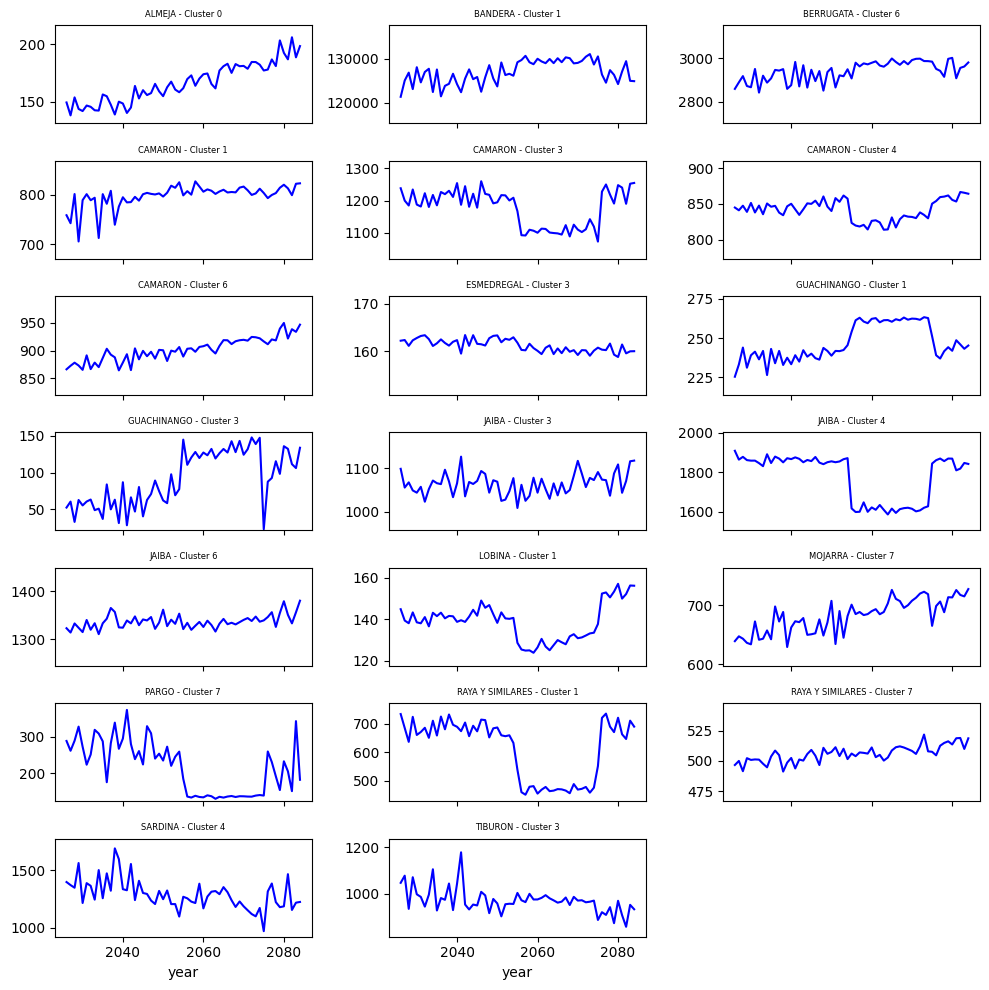

Figura guardada en Resultados\promedios_anuales_predicciones_con_media_y_moda_historica.png


In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Directorio donde se encuentran los archivos de predicciones y datos históricos
results_directory = 'Resultados'
historical_data_path = 'data/data.csv'  # Ruta al archivo de datos históricos

# Especies y configuraciones a omitir
omit_species = [('Sierra', 5), ('Baqueta', None), ('Almeja', None), ('Mojarra', 2)]

# Cargar los datos históricos
historical_data = pd.read_csv(historical_data_path)
historical_data['date'] = pd.to_datetime(historical_data['date'])
historical_data['year'] = historical_data['date'].dt.year

# Obtener la lista de archivos de predicciones
prediction_files = [f for f in os.listdir(results_directory) if f.startswith('predicciones_') and f.endswith('.csv')]

# Inicializar un diccionario para almacenar los datos de cada especie
species_data = {}

# Leer cada archivo y organizar los datos para cada especie
for file in prediction_files:
    # Extraer el nombre de la especie y el clúster del nombre del archivo
    parts = file.split('_')
    species_name = parts[1]
    cluster_label = int(parts[3].replace('.csv', '').replace('cluster', '').strip())
    
    # Omitir las especies y clústeres especificados
    if (species_name, None) in omit_species or (species_name, cluster_label) in omit_species:
        continue
    
    # Leer el archivo de predicciones
    file_path = os.path.join(results_directory, file)
    df = pd.read_csv(file_path)
    
    # Asegurar que la columna 'date' sea de tipo datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Filtrar las predicciones después del año 2025
    df = df[df['date'] > pd.to_datetime('2026-01-01')]
    
    df['year'] = df['date'].dt.year
    
    # Calcular el promedio anual
    annual_avg_predictions = df.groupby('year')['predictions'].mean().reset_index()
    
    # Filtrar los datos históricos para la especie actual
    historical_species_data = historical_data[historical_data['species'] == species_name]
    
    # Calcular la media total de los datos históricos
    historical_mean = historical_species_data['landed_w_kg'].mean()
    historical_mode = historical_species_data['landed_w_kg'].mode().values[0] if not historical_species_data['landed_w_kg'].mode().empty else np.nan
    
    # Almacenar los datos en el diccionario
    species_data[(species_name, cluster_label)] = {
        'predictions': annual_avg_predictions,
        'historical_mean': historical_mean,
        'historical_mode': historical_mode
    }

# Crear la figura para las gráficas con subplots
num_species = len(species_data)
cols = 3  # Número de columnas en la matriz de gráficos
rows = (num_species + cols - 1) // cols  # Número de filas, calculado de manera que todas las especies tengan su gráfica
fig, axes = plt.subplots(rows, cols, figsize=(10, 10), sharex=True, sharey=False)
axes = axes.flatten()

# Si hay menos gráficos que subplots, ocultar los subplots vacíos
for i in range(len(axes)):
    if i >= num_species:
        axes[i].axis('off')

# Iterar sobre cada especie para crear las gráficas
for ax, ((species_name, cluster_label), stats) in zip(axes, species_data.items()):
    predictions = stats['predictions']
    historical_mean = stats['historical_mean']
    historical_mode = stats['historical_mode']
    
    # Graficar los promedios anuales de las predicciones con Seaborn
    sns.lineplot(x='year', y='predictions', data=predictions, ax=ax, color='blue')
    
    # Graficar la línea horizontal de la media histórica en naranja (comentado, si no es necesario)
    # ax.axhline(y=historical_mean, color='orange', linestyle='-', label='Media Histórica')
    
    # Graficar la línea horizontal de la moda histórica en rojo (comentado, si no es necesario)
    # ax.axhline(y=historical_mode, color='red', linestyle='-', label='Moda Histórica')
    
    # Ajustar el eje y solo si los límites son válidos
    min_y = min(predictions['predictions'])
    max_y = max(predictions['predictions'])
    
    if np.isfinite(min_y) and np.isfinite(max_y):
        ax.set_ylim(min_y * 0.95, max_y * 1.05)  # Margen de 5% por encima y debajo de los valores mínimos y máximos
    
    # Configurar los ejes y el título
    ax.set_title(f'{species_name} - Cluster {cluster_label}', fontsize=6)
    ax.set_ylabel("")  # Eliminar la etiqueta del eje y

# Ajustar el layout para que las gráficas no se solapen
plt.tight_layout()

# Guardar la figura
fig_path = os.path.join(results_directory, 'promedios_anuales_predicciones_con_media_y_moda_historica.png')
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Figura guardada en {fig_path}")


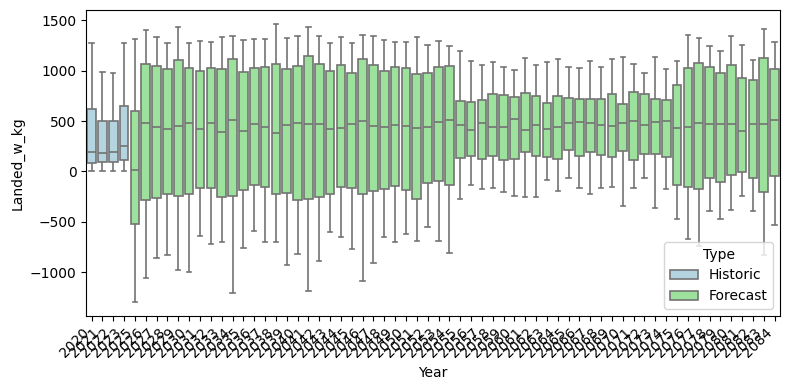

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directorio donde se encuentran los archivos de predicciones y datos históricos
results_directory = 'Resultados'
historical_data_path = 'data/data.csv'  # Ruta al archivo de datos históricos
sp = 'CORVINA'
cluster_number = 6  # Especifica el número del clúster que deseas seleccionar

# Cargar los datos históricos
historical_data = pd.read_csv(historical_data_path)
historical_data['date'] = pd.to_datetime(historical_data['date'])

# Filtrar los datos históricos para la especie seleccionada
historical_data = historical_data[historical_data['species'] == sp]

# Agregar los datos históricos por año
historical_data['year'] = historical_data['date'].dt.year
historical_data['Type'] = 'Historic'

# Obtener la lista de archivos de predicciones que coincidan con la especie y el clúster
prediction_files = [
    f for f in os.listdir(results_directory) 
    if f.startswith(f'predicciones_{sp}_cluster_{cluster_number}') and f.endswith('.csv')
]

# Inicializar un DataFrame para almacenar los datos de predicciones anuales
all_predictions = pd.DataFrame()

# Leer cada archivo y agregar los datos de predicciones anuales
for file in prediction_files:
    # Leer el archivo de predicciones
    file_path = os.path.join(results_directory, file)
    df = pd.read_csv(file_path)
    
    # Asegurar que la columna 'date' sea de tipo datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Agregar los datos de predicciones por año
    df['year'] = df['date'].dt.year
    df['Type'] = 'Forecast'
    
    # Añadir las predicciones al DataFrame principal
    all_predictions = pd.concat([all_predictions, df[['year', 'predictions', 'Type']]], ignore_index=True)

# Renombrar la columna 'predictions' en el DataFrame de predicciones para unificar con el histórico
all_predictions.rename(columns={'predictions': 'landed_w_kg'}, inplace=True)

# Combinar los datos históricos y las predicciones en un solo DataFrame
combined_data = pd.concat([historical_data[['year', 'landed_w_kg', 'Type']], all_predictions], ignore_index=True)

# Filtrar los datos para mostrar solo los años a partir de 2020
combined_data = combined_data[combined_data['year'] >= 2020]

# Configurar la paleta de colores para diferenciar entre 'Historico' y 'Pronostico'
palette = {'Historic': 'lightblue', 'Forecast': 'lightgreen'}

# Crear la figura para la gráfica de boxplot con seaborn
plt.figure(figsize=(8, 4))

# Crear el boxplot usando seaborn
sns.boxplot(x='year', y='landed_w_kg', hue='Type', data=combined_data, palette=palette, linewidth=1.2, whis=1.2,showfliers=False)

# Mejorar la legibilidad de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Configurar los ejes y el título
#plt.title(f'Boxplot of Predictions and Historical Data for {sp} - Cluster {cluster_number}')
plt.xlabel('Year')
plt.ylabel('Landed_w_kg')
plt.grid(False)

# Ajustar el layout
plt.tight_layout()

In [6]:
f_df = pd.read_csv('future_data.csv',low_memory=False)


In [7]:
f_df['date'] = pd.to_datetime(f_df['year'].astype(str) + '-' + f_df['month'].astype(str) + '-01')

# Crear la columna 'type' en ambos DataFrames
data['type'] = 'real'
f_df['type'] = 'forecast'

# Concatenar las columnas 'mean_temp_10m' de ambos DataFrames y agregar la columna 'type'
data_concat = pd.concat([
    data[['date', 'mean_temp_10m', 'type']],
    f_df[['date', 'depth_mean_10m', 'type']].rename(columns={'depth_mean_10m': 'mean_temp_10m'})
])

# Asegurarse de que las fechas estén ordenadas si es necesario
data_concat = data_concat.sort_values(by='date').reset_index(drop=True)

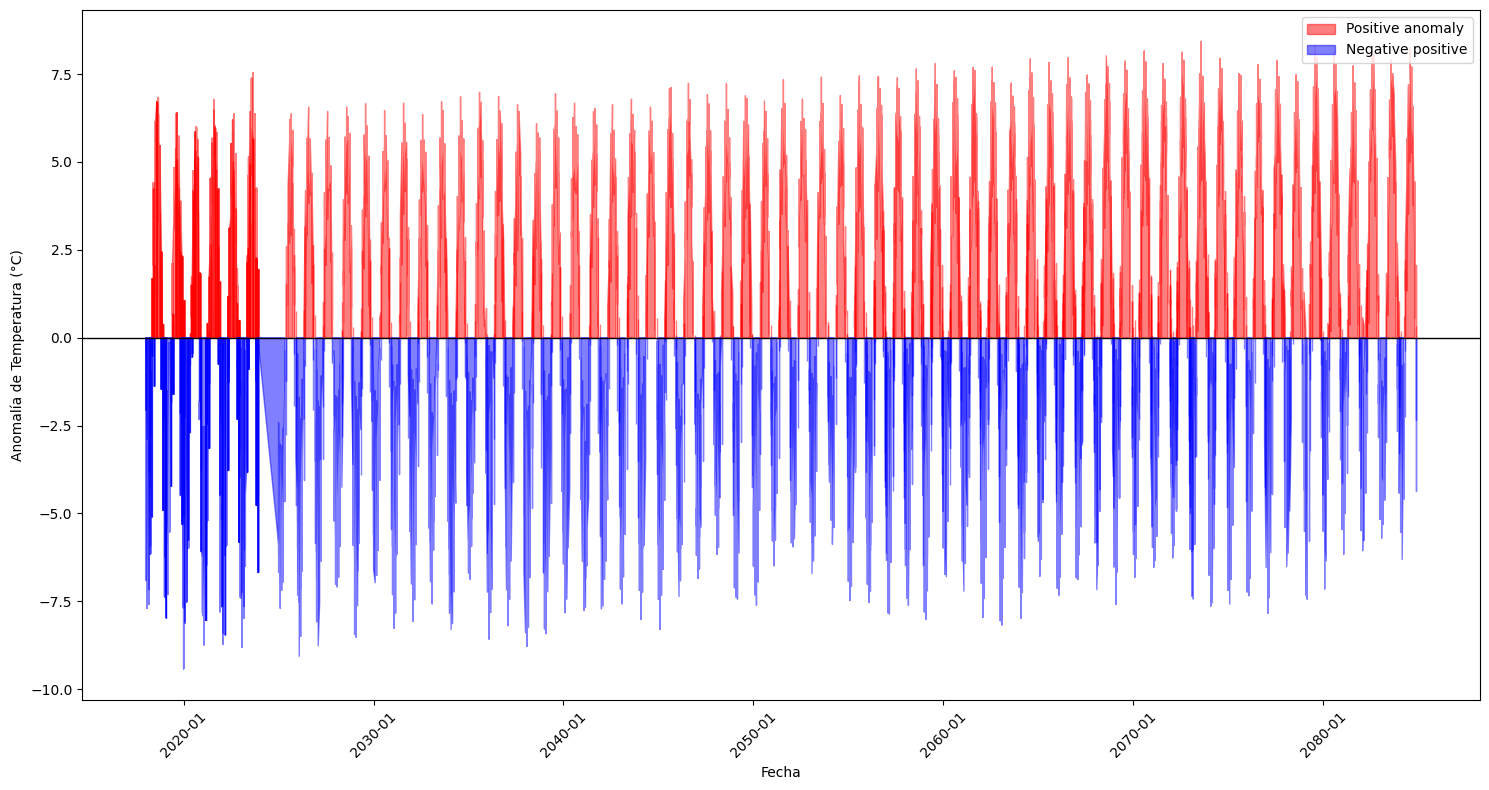

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Supongamos que ya filtraste los datos para incluir solo el tipo 'real'
real_data = data_concat[data_concat['type'] == 'real']

# Asegurarse de que la columna 'date' esté en formato datetime
data_concat['date'] = pd.to_datetime(data_concat['date'], format='%Y-%m')

# Calcular la media de la columna 'mean_temp_10m' solo para los datos de tipo 'real'
mean_temp_real = real_data['mean_temp_10m'].mean()

# Calcular las anomalías en todo el DataFrame utilizando la media de los datos reales
data_concat['anomaly'] = data_concat['mean_temp_10m'] - mean_temp_real

# Crear la figura y los ejes
plt.figure(figsize=(15, 8))

# Sombrear áreas para anomalías positivas y negativas
plt.fill_between(data_concat['date'], data_concat['anomaly'], where=(data_concat['anomaly'] > 0), 
                 color='red', alpha=0.5, label='Positive anomaly')
plt.fill_between(data_concat['date'], data_concat['anomaly'], where=(data_concat['anomaly'] <= 0), 
                 color='blue', alpha=0.5, label='Negative positive')

# Personalizar el gráfico
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Fecha')
plt.ylabel('Anomalía de Temperatura (°C)')

# Formatear las etiquetas del eje x para mostrar fechas
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()

# Mostrar el gráfico
plt.show()


In [9]:
data_concat.to_csv('temp.csv')

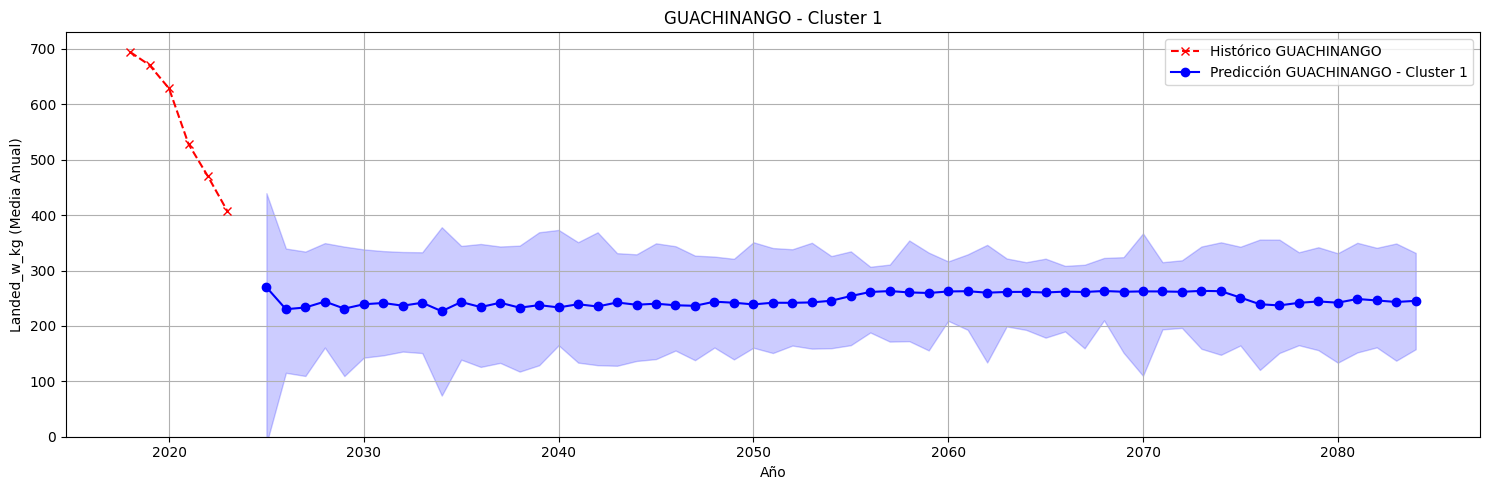

Figura guardada en Resultados\media_anual_predicciones_con_historico_GUACHINANGO_cluster_1.png


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directorio donde se encuentran los archivos de predicciones y datos históricos
results_directory = 'Resultados'
historical_data_path = 'data/data.csv'  # Ruta al archivo de datos históricos

# Parámetros para la especie y clúster que deseas graficar
selected_species = 'GUACHINANGO'  # Reemplaza con el nombre de la especie
selected_cluster = 1  # Reemplaza con el número del clúster deseado

# Cargar los datos históricos
historical_data = pd.read_csv(historical_data_path)
historical_data['date'] = pd.to_datetime(historical_data['date'])
historical_data['year'] = historical_data['date'].dt.year

# Obtener la lista de archivos de predicciones
prediction_files = [f for f in os.listdir(results_directory) if f.startswith('predicciones_') and f.endswith('.csv')]

# Inicializar un diccionario para almacenar los datos de la especie seleccionada
species_data = {}

# Leer cada archivo y calcular la media anual de las predicciones
for file in prediction_files:
    # Extraer el nombre de la especie y el clúster del nombre del archivo
    parts = file.split('_')
    species_name = parts[1]
    cluster_label = int(parts[3].replace('.csv', '').replace('cluster', '').strip())
    
    # Verificar si la especie y el clúster coinciden con los seleccionados
    if species_name == selected_species and cluster_label == selected_cluster:
        # Leer el archivo de predicciones
        file_path = os.path.join(results_directory, file)
        df = pd.read_csv(file_path)
        
        # Asegurar que la columna 'date' sea de tipo datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Filtrar los datos históricos para la especie actual
        historical_species_data = historical_data[historical_data['species'] == species_name]
        
        # Calcular el orden de magnitud si se necesita (por ahora, se usa 1 como en el código original)
        order_of_magnitude = 1
        
        # Multiplicar las predicciones por el orden de magnitud
        df['predictions'] = df['predictions'] * order_of_magnitude
        
        # Calcular la media, máximo y mínimo mensual de las predicciones
        df['year'] = df['date'].dt.year
        monthly_stats = df.groupby(['year', df['date'].dt.month])['predictions'].agg(['mean', 'max', 'min']).reset_index()
        
        # Calcular la media anual, máximo y mínimo anual
        annual_mean = monthly_stats.groupby('year')['mean'].mean().reset_index()
        annual_max = monthly_stats.groupby('year')['max'].max().reset_index()
        annual_min = monthly_stats.groupby('year')['min'].min().reset_index()
        
        # Almacenar los datos en el diccionario
        species_data[species_name] = {
            'mean': annual_mean, 
            'max': annual_max, 
            'min': annual_min,
            'historical': historical_species_data.groupby('year')['landed_w_kg'].mean().reset_index()
        }

# Verificar si se encontró la especie y clúster seleccionados
if species_data:
    # Crear la figura para la gráfica
    fig, ax = plt.subplots(figsize=(15, 5))

    # Obtener los datos de la especie seleccionada
    stats = species_data[selected_species]
    annual_mean = stats['mean']
    annual_max = stats['max']
    annual_min = stats['min']
    historical = stats['historical']
    
    # Graficar la línea de los datos históricos
    ax.plot(historical['year'], historical['landed_w_kg'], marker='x', linestyle='--', color='red', label=f'Histórico {selected_species}')
    
    # Graficar la línea de media anual de las predicciones, comenzando desde el último valor histórico
    if not historical.empty:
        last_historical_year = historical['year'].max()
        first_prediction_year = annual_mean['year'].min()
        if last_historical_year == first_prediction_year:
            ax.plot([last_historical_year, last_historical_year], [historical['landed_w_kg'].iloc[-1], annual_mean['mean'].iloc[0]], color='blue')
    
    # Graficar la línea de predicciones
    ax.plot(annual_mean['year'], annual_mean['mean'], marker='o', linestyle='-', color='blue', label=f'Predicción {selected_species} - Cluster {selected_cluster}')
    
    # Graficar el área entre el máximo y mínimo anual para las predicciones
    ax.fill_between(annual_mean['year'], annual_min['min'], annual_max['max'], color='blue', alpha=0.2)
    
    # Configurar los ejes y el título
    ax.set_ylabel('Landed_w_kg (Media Anual)')
    ax.set_title(f'{selected_species} - Cluster {selected_cluster}')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, None)  # Asegurar que el eje y empiece desde 0

    # Configurar el eje x compartido
    plt.xlabel('Año')

    # Ajustar el layout
    plt.tight_layout()

    # Guardar la figura
    fig_path = os.path.join(results_directory, f'media_anual_predicciones_con_historico_{selected_species}_cluster_{selected_cluster}.png')
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"Figura guardada en {fig_path}")
else:
    print(f"No se encontraron datos para la especie '{selected_species}' y el clúster '{selected_cluster}'.")


C:\Users\ricar\AppData\Local\Temp\ipykernel_10960\3777433925.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'r')).reset_index(drop=True)


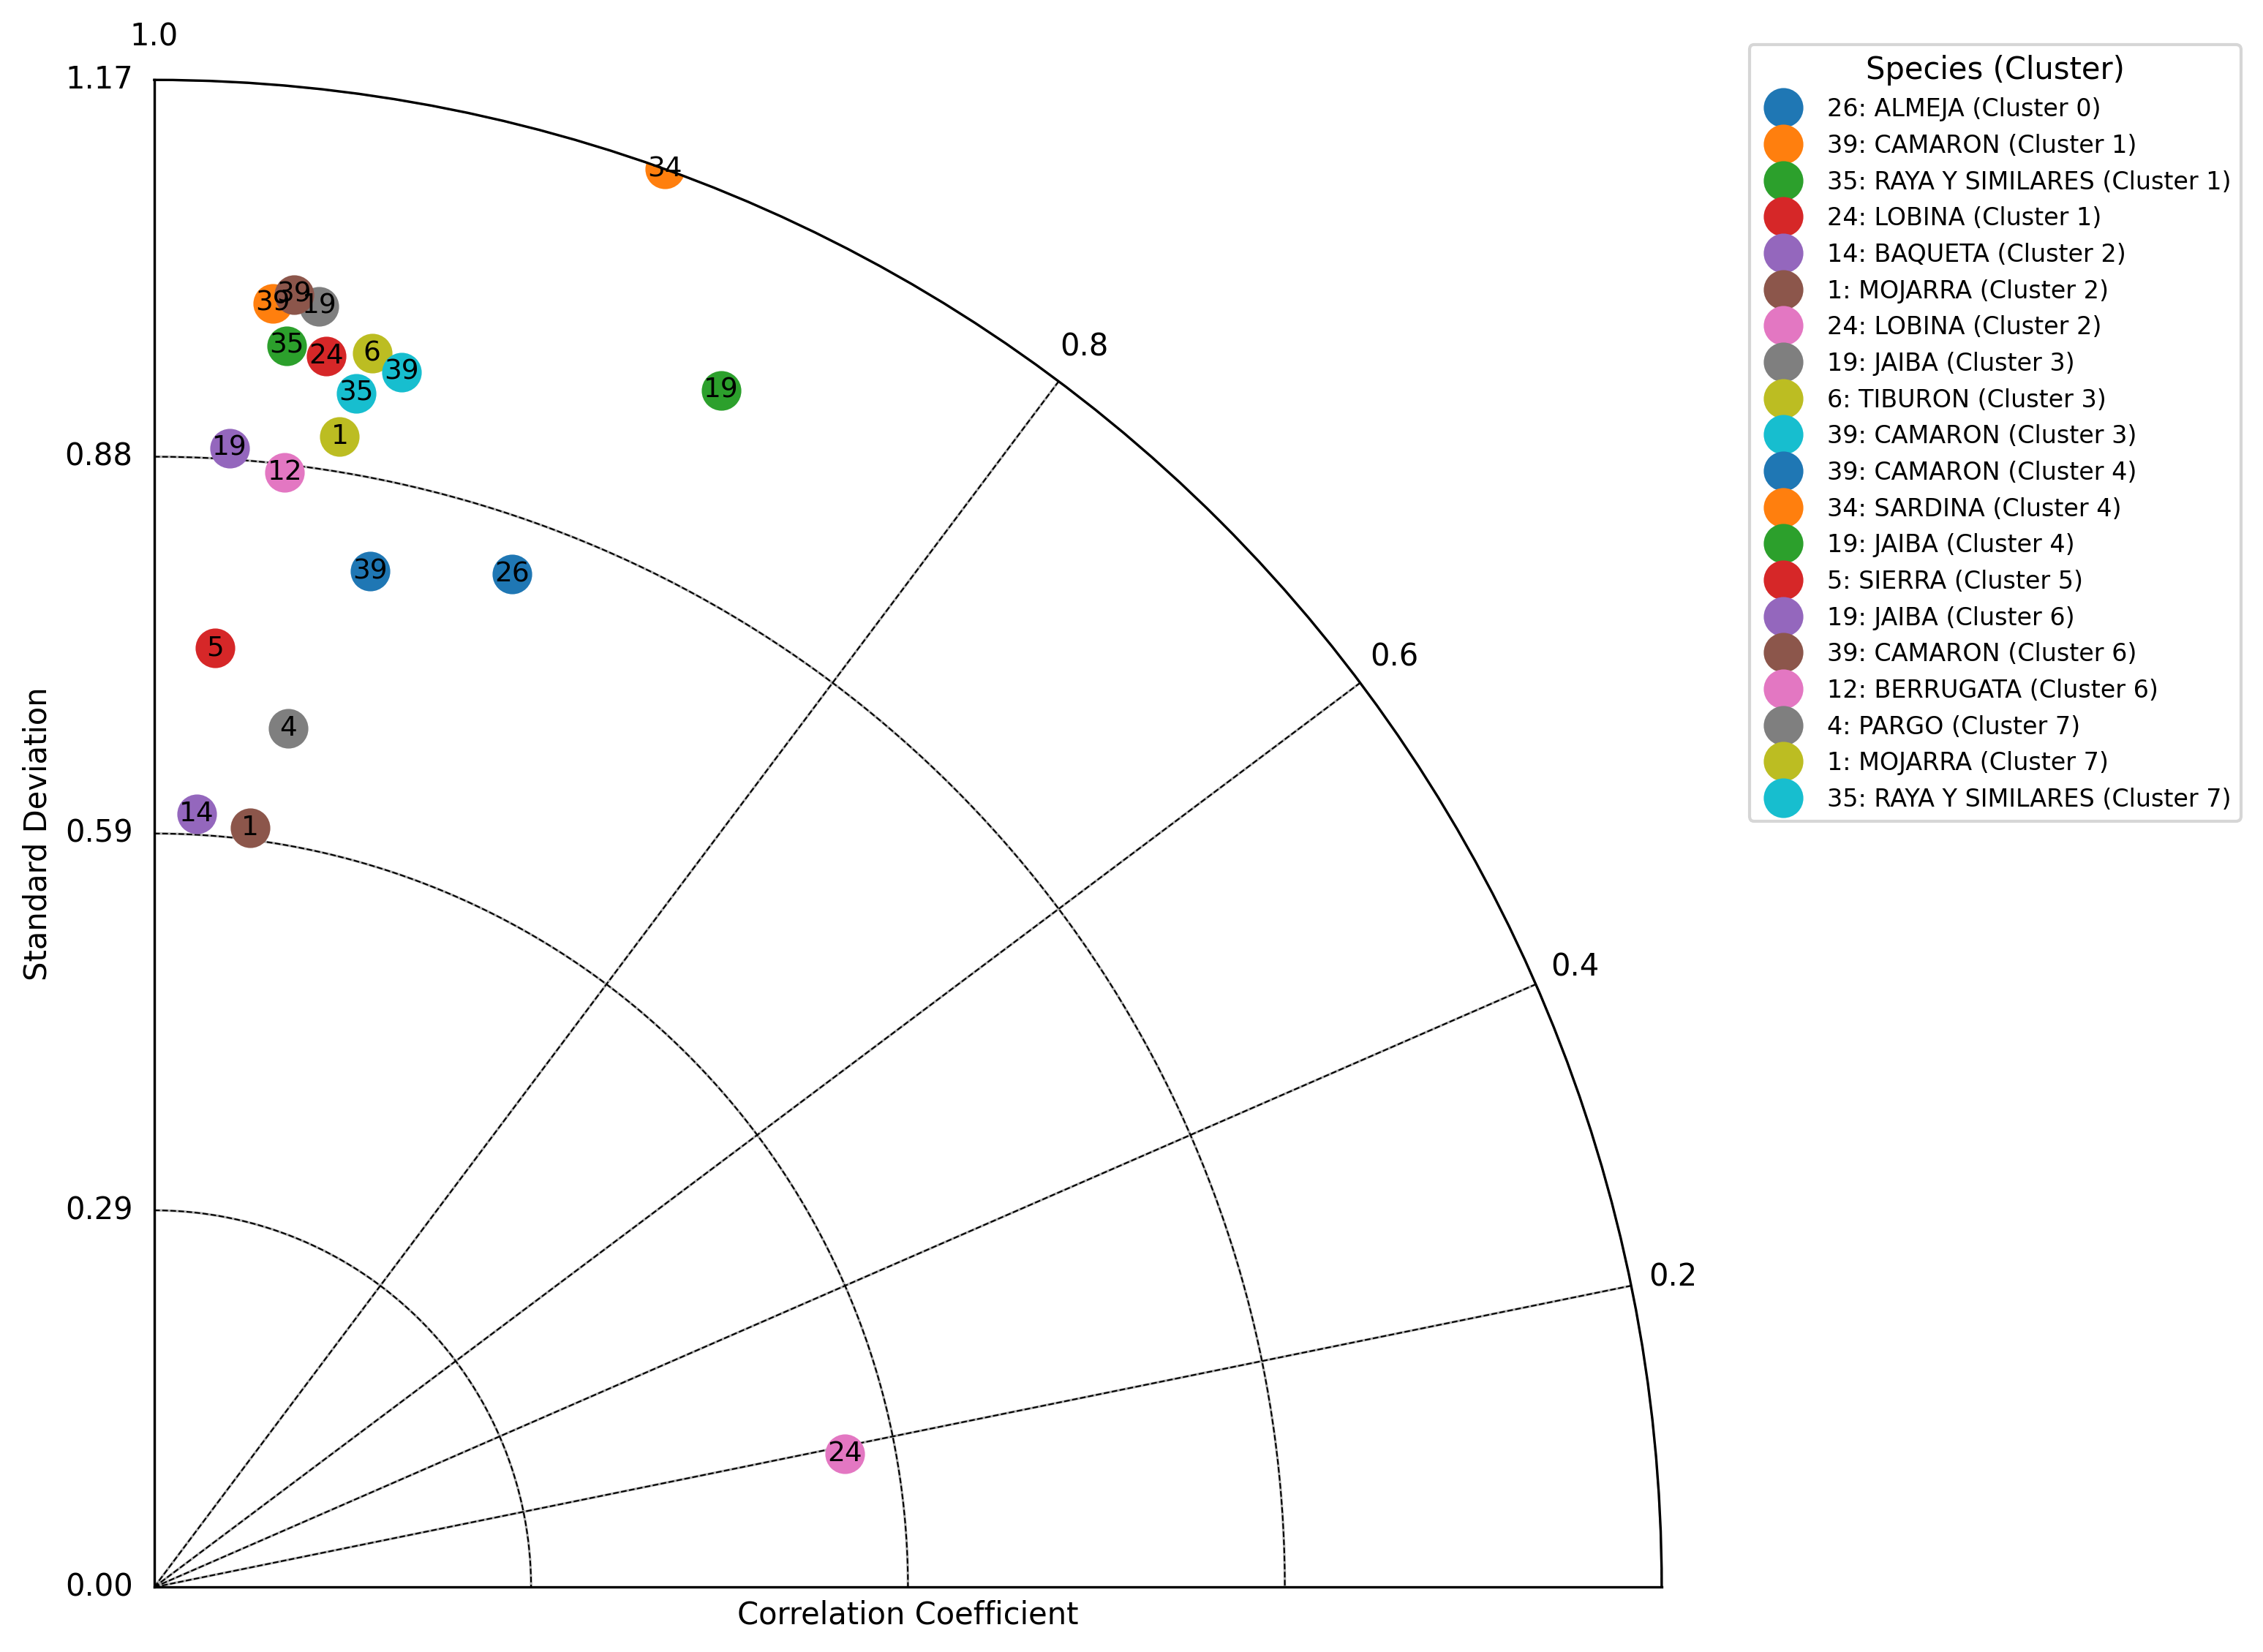

Mejores modelos por clúster:
             species  cluster    stddev         r
0             ALMEJA        0  0.834650  0.942965
1            CAMARON        1  1.001678  0.995765
2   RAYA Y SIMILARES        1  0.970023  0.994364
3             LOBINA        1  0.965775  0.990413
4            BAQUETA        2  0.601602  0.998510
5            MOJARRA        2  0.594663  0.992158
6             LOBINA        2  0.546408  0.189802
7              JAIBA        3  1.003262  0.991804
8            TIBURON        3  0.973352  0.984779
9            CAMARON        3  0.963451  0.979895
10           CAMARON        4  0.806751  0.978211
11           SARDINA        4  1.170945  0.940951
12             JAIBA        4  1.028822  0.903816
13            SIERRA        5  0.730926  0.997895
14             JAIBA        6  0.886921  0.997817
15           CAMARON        6  1.009985  0.994230
16         BERRUGATA        6  0.872201  0.993207
17             PARGO        7  0.675340  0.988006
18           MOJARRA 

In [11]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar una lista para almacenar los valores de rendimiento
performance_data = []

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r y stddev
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                
                # Manejar casos donde la desviación estándar es 0 para evitar divisiones por 0
                if std_obs > 0 and std_pred > 0:
                    corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                else:
                    corr = np.nan  # Si no se puede calcular, asignar NaN

                # Agregar solo si no hay NaN
                if not np.isnan(corr):
                    performance_data.append({
                        'species': species_name,
                        'cluster': cluster_label,
                        'stddev': std_pred / std_obs,
                        'r': corr
                    })

# Convertir la lista en un DataFrame
performance_df = pd.DataFrame(performance_data)

# Seleccionar el mejor modelo para cada clúster
best_models_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'r')).reset_index(drop=True)

# Parámetros de tamaño de figura y DPI
fig_size = (10, 10)  # Puedes modificar estas dimensiones
fig_dpi = 300  # Puedes modificar la resolución

# Crear la figura para el diagrama de Taylor único
fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'polar': True}, dpi=fig_dpi)

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_labels, cluster_labels, marker_size=10):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi/2, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo con un marcador por cada cluster
    for i, (std, t) in enumerate(zip(stddev, theta)):
        species_code = species_to_num[species_labels[i]]
        ax.plot(t, std, 'o', label=f'{species_labels[i]} (Cluster {cluster_labels[i]})', markersize=marker_size)
        ax.text(t, std, str(species_code), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(90)  # Mostrar solo un cuarto de la circunferencia
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.grid(True)
    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Preparar datos para el diagrama de Taylor
stddev = best_models_per_cluster['stddev'].tolist()
corrcoef = best_models_per_cluster['r'].tolist()
species_labels = best_models_per_cluster['species'].tolist()
cluster_labels = best_models_per_cluster['cluster'].tolist()

# Crear el diagrama de Taylor único
taylor_diagram(ax, stddev, corrcoef, species_labels, cluster_labels, marker_size=12)

# Añadir una leyenda única
handles, labels = ax.get_legend_handles_labels()
legend_labels = [f'{species_to_num[species]}: {species} (Cluster {cluster})' for species, cluster in zip(species_labels, cluster_labels)]
ax.legend(handles, legend_labels, loc='lower left', bbox_to_anchor=(1.05, 0.5), fontsize=8, title="Species (Cluster)")

# Ajustar el layout
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Dejar espacio para la leyenda fuera del gráfico
plt.show()

# Imprimir la lista de los mejores modelos por clúster
print("Mejores modelos por clúster:")
print(best_models_per_cluster)


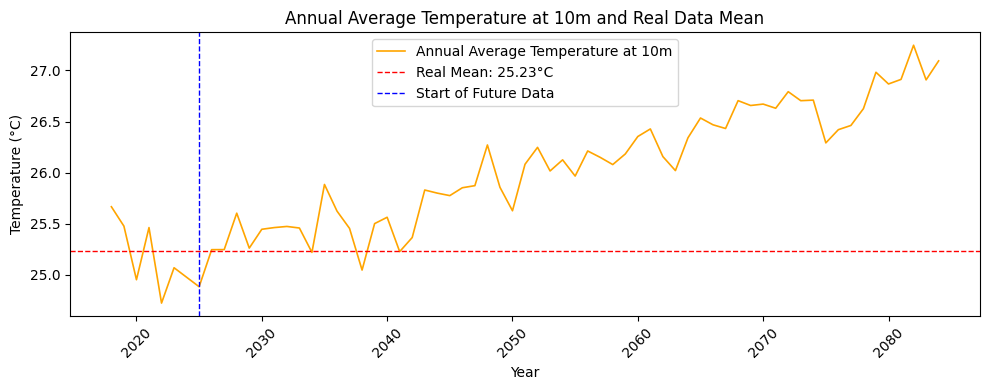

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the data includes only the 'real' type
real_data = data_concat[data_concat['type'] == 'real']

# Make sure the 'date' column is in datetime format
data_concat['date'] = pd.to_datetime(data_concat['date'], format='%Y-%m')

# Calculate the mean of the 'mean_temp_10m' column only for real data
mean_temp_real = real_data['mean_temp_10m'].mean()

# Calculate the annual average temperature at 10m
data_concat['Year'] = data_concat['date'].dt.year
annual_avg = data_concat.groupby('Year')['mean_temp_10m'].mean().reset_index()

# Create the figure and axes
plt.figure(figsize=(10, 4))

# Plot the line of annual average temperatures
plt.plot(annual_avg['Year'], annual_avg['mean_temp_10m'], color='orange', linewidth=1.2, marker='', label='Annual Average Temperature at 10m')

# Add a horizontal line for the mean of the real data
plt.axhline(mean_temp_real, color='red', linestyle='--', linewidth=1, label=f'Real Mean: {mean_temp_real:.2f}°C')

# Determine the start year for future data
future_start_year = 2025  # Adjust as needed

# Add a vertical line to separate historical data from future data
plt.axvline(future_start_year, color='blue', linestyle='--', linewidth=1, label='Start of Future Data')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Annual Average Temperature at 10m and Real Data Mean')

# Set x-axis ticks to show every 10 years starting from the closest multiple of 10 near 2018
start_year = 2020  # Adjust this start year as needed based on your data range
plt.xticks(ticks=range(start_year, annual_avg['Year'].max() + 1, 10), rotation=45)

plt.tight_layout()
plt.legend()

# Show the plot
plt.show()


C:\Users\ricar\AppData\Local\Temp\ipykernel_10960\3701635930.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'r')).reset_index(drop=True)


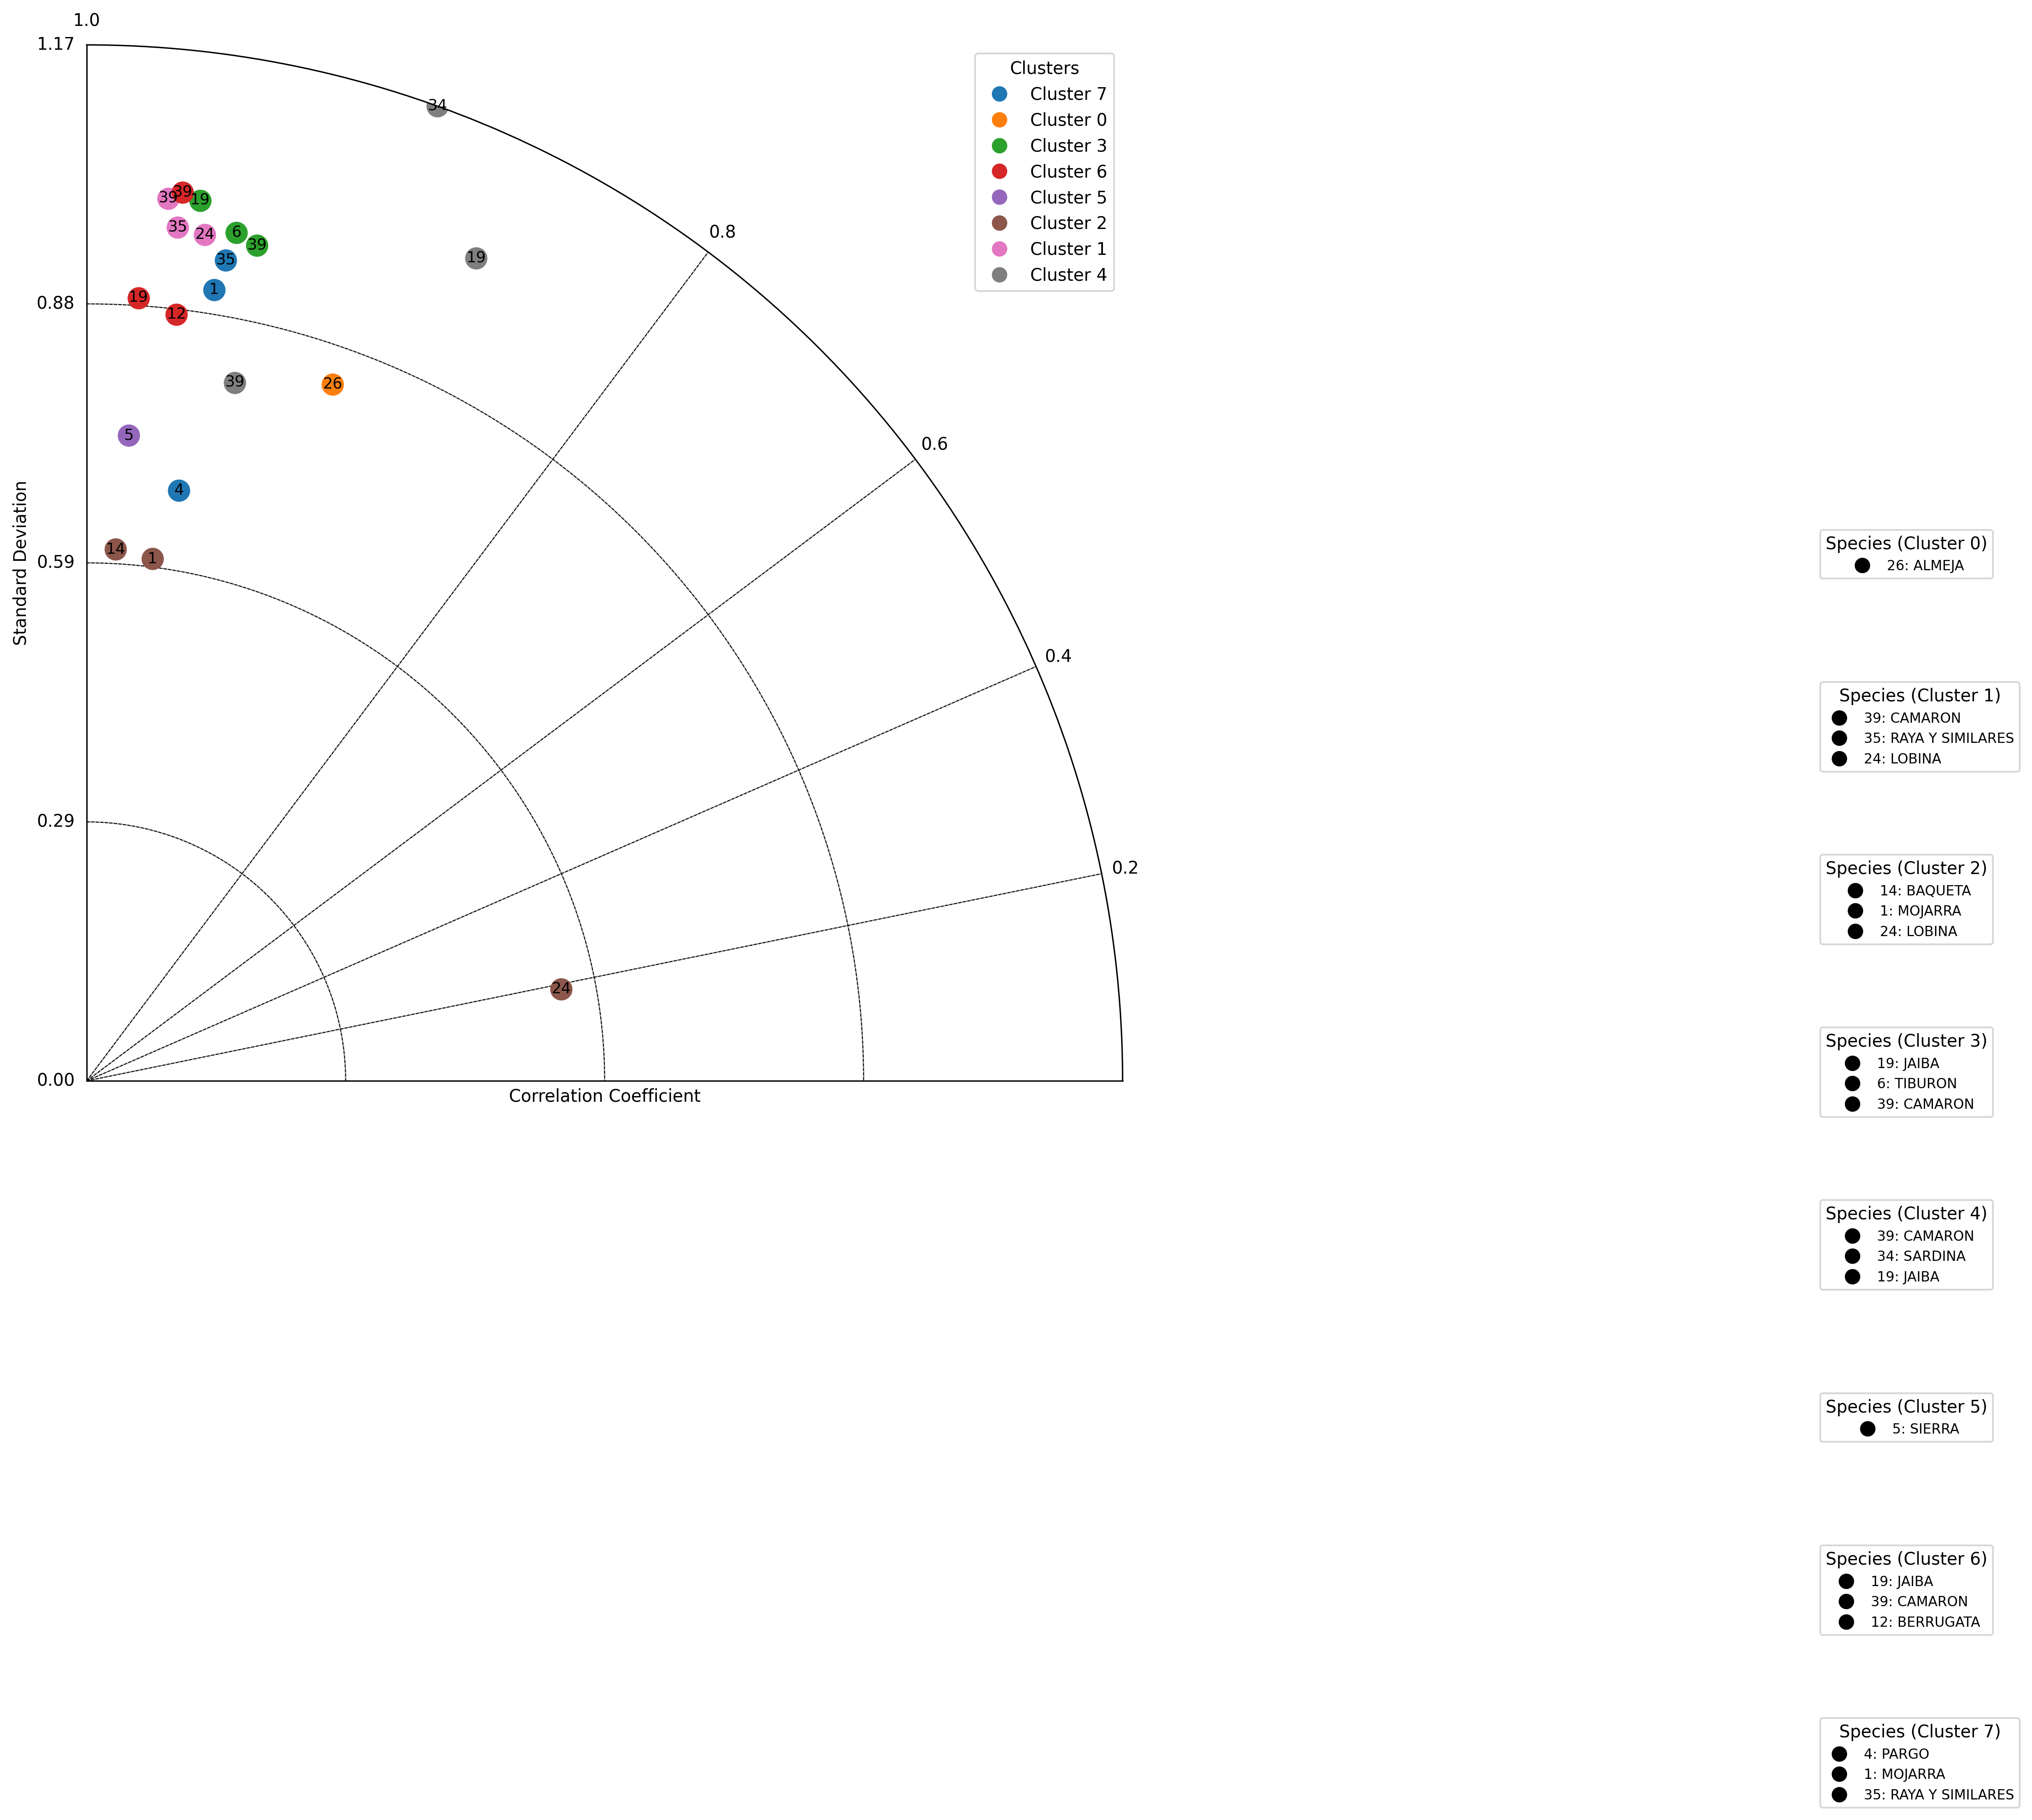

In [13]:
import os
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar una lista para almacenar los valores de rendimiento
performance_data = []

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r y stddev
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular las métricas
            if len(monthly_totals) >= 2:
                std_obs = np.std(monthly_totals['real_values'])
                std_pred = np.std(monthly_totals['predictions'])
                
                # Manejar casos donde la desviación estándar es 0 para evitar divisiones por 0
                if std_obs > 0 and std_pred > 0:
                    corr, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                else:
                    corr = np.nan  # Si no se puede calcular, asignar NaN

                # Agregar solo si no hay NaN
                if not np.isnan(corr):
                    performance_data.append({
                        'species': species_name,
                        'cluster': cluster_label,
                        'stddev': std_pred / std_obs,
                        'r': corr
                    })

# Convertir la lista en un DataFrame
performance_df = pd.DataFrame(performance_data)

# Seleccionar el mejor modelo para cada clúster
best_models_per_cluster = performance_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'r')).reset_index(drop=True)

# Mapeo de especies a números
species_to_num = {species: num for num, species in enumerate(unique_species, 1)}

# Preparar datos para el diagrama de Taylor
stddev = best_models_per_cluster['stddev'].tolist()
corrcoef = best_models_per_cluster['r'].tolist()
species_labels = best_models_per_cluster['species'].tolist()
cluster_labels = best_models_per_cluster['cluster'].tolist()

# Filtrar leyendas de especies para mostrar solo las que aparecen en la gráfica
unique_species_in_graph = set(species_labels)
filtered_species_to_num = {species: num for species, num in species_to_num.items() if species in unique_species_in_graph}

# Agrupar especies por clúster para la leyenda
species_by_cluster = {}
for species, cluster in zip(species_labels, cluster_labels):
    if cluster not in species_by_cluster:
        species_by_cluster[cluster] = []
    species_by_cluster[cluster].append(f'{filtered_species_to_num[species]}: {species}')

# Crear la figura para el diagrama de Taylor
fig, ax = plt.subplots(figsize=(14, 14), subplot_kw={'polar': True}, dpi=300)  # Aumentar el tamaño de la figura

# Función para crear el diagrama de Taylor
def taylor_diagram(ax, stddev, corrcoef, species_labels, cluster_labels, cluster_colors, species_to_num, marker_size=10):
    # Conversión del coeficiente de correlación a ángulos
    theta = np.arccos(corrcoef)
    
    # Dibujar círculos de referencia para la desviación estándar
    for std in np.linspace(0, max(stddev), 5):
        ax.plot(np.linspace(0, np.pi/2, 100), np.full(100, std), 'k--', lw=0.5)

    # Dibujar líneas de referencia para el coeficiente de correlación
    for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot([np.arccos(r)]*100, np.linspace(0, max(stddev), 100), 'k--', lw=0.5)

    # Añadir puntos para cada modelo con un marcador por cada clúster
    for i, (std, t) in enumerate(zip(stddev, theta)):
        ax.plot(t, std, 'o', color=cluster_colors[cluster_labels[i]], markersize=marker_size)
        ax.text(t, std, str(species_to_num[species_labels[i]]), fontsize=9, ha='center', va='center')

    # Configurar el eje
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(90)  # Mostrar solo un cuarto de la circunferencia
    ax.set_rlim(0, max(stddev))
    ax.set_yticks(np.linspace(0, max(stddev), 5))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(0, max(stddev), 5)])
    ax.set_xticks(np.arccos([0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

    ax.grid(True)
    # Añadir títulos a los ejes
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Standard Deviation')

# Asignar colores únicos a cada clúster
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, plt.cm.tab10(range(len(unique_clusters))))}

# Crear el diagrama de Taylor único
taylor_diagram(ax, stddev, corrcoef, species_labels, cluster_labels, cluster_colors, species_to_num, marker_size=12)

# Crear leyenda de clústeres (solo colores)
handles_cluster = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}', 
                              markerfacecolor=color, markersize=10) for cluster, color in cluster_colors.items()]

# Añadir la leyenda de clústeres
ax.legend(handles_cluster, [f'Cluster {i}' for i in cluster_colors.keys()], loc='upper right', title='Clusters')

# Añadir leyenda de especies agrupadas por clúster
fig.subplots_adjust(right=0.7, left=0.1)  # Ajustar espacio para leyendas
# Iterar sobre los clústeres y añadir subleyendas para especies
for cluster, species_list in species_by_cluster.items():
    fig.legend([plt.Line2D([0], [0], marker='o', color='w', label=spec, markerfacecolor='black', markersize=10) 
                for spec in species_list], species_list, loc='center left', bbox_to_anchor=(1.1, 0.5 - 0.1 * cluster), 
               fontsize=8, title=f"Species (Cluster {cluster})", ncol=1)

# Mostrar la gráfica
plt.show()


In [14]:
import os
import pandas as pd
import numpy as np

# Directorio donde se encuentran los archivos de predicciones y datos históricos
results_directory = 'Resultados'
historical_data_path = 'data/data.csv'  # Ruta al archivo de datos históricos

# Especies y configuraciones a omitir
omit_species = [('Sierra', 5), ('Baqueta', None), ('Almeja', None), ('Mojarra', 2)]

# Cargar los datos históricos
historical_data = pd.read_csv(historical_data_path)
historical_data['date'] = pd.to_datetime(historical_data['date'])
historical_data['year'] = historical_data['date'].dt.year

# Filtrar los datos del año 2020 y calcular la media del peso desembarcado por especie
historical_2020 = historical_data[historical_data['year'] == 2020]
historical_means_2020 = historical_2020.groupby('species')['landed_w_kg'].mean()

# Obtener la lista de archivos de predicciones
prediction_files = [f for f in os.listdir(results_directory) if f.startswith('predicciones_') and f.endswith('.csv')]

# Inicializar un diccionario para almacenar los datos de cada especie
species_data = {}

# Leer cada archivo y organizar los datos para cada especie
for file in prediction_files:
    # Extraer el nombre de la especie y el clúster del nombre del archivo
    parts = file.split('_')
    species_name = parts[1]
    cluster_label = int(parts[3].replace('.csv', '').replace('cluster', '').strip())
    
    # Omitir las especies y clústeres especificados
    if (species_name, None) in omit_species or (species_name, cluster_label) in omit_species:
        continue
    
    # Leer el archivo de predicciones
    file_path = os.path.join(results_directory, file)
    df = pd.read_csv(file_path)
    
    # Asegurar que la columna 'date' sea de tipo datetime
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    
    # Filtrar las predicciones para los años deseados
    df = df[df['year'].isin([2030, 2040, 2050, 2060])]
    
    # Calcular la media anual de las predicciones
    annual_mean_predictions = df.groupby('year')['predictions'].mean()
    
    # Almacenar los datos en el diccionario incluyendo el año 2020 de los datos históricos
    if species_name in historical_means_2020:
        annual_mean_predictions[2020] = historical_means_2020[species_name]
    
    species_data[(species_name, cluster_label)] = annual_mean_predictions

# Crear un DataFrame con especies como índices y los años seleccionados como columnas
years = [2020, 2030, 2040, 2050, 2060]
species_index = [f'{species} - Cluster {cluster}' for species, cluster in species_data.keys()]
mean_table = pd.DataFrame(index=species_index, columns=years)

# Llenar la tabla con los valores de media
for (species_name, cluster_label), means in species_data.items():
    index = f'{species_name} - Cluster {cluster_label}'
    for year in years:
        if year in means:
            mean_table.loc[index, year] = means[year]

# Mostrar la tabla resultante
print(mean_table)
mean_table.to_csv('tabla_mean.csv')

                                     2020           2030           2040  \
ALMEJA - Cluster 0            1390.597786     142.121884     148.647293   
BANDERA - Cluster 1            343.197398  128068.932586  124198.032697   
BERRUGATA - Cluster 6           991.49391    2865.937704    2875.639685   
CAMARON - Cluster 1           1551.127634     789.279558     795.135878   
CAMARON - Cluster 3           1551.127634    1187.664154    1254.118048   
CAMARON - Cluster 4           1551.127634     851.378435     850.219752   
CAMARON - Cluster 6           1551.127634     865.363354     878.467464   
ESMEDREGAL - Cluster 3          38.333333     162.753197     162.300768   
GUACHINANGO - Cluster 1         628.57407     239.075614     233.410694   
GUACHINANGO - Cluster 3         628.57407      55.316979      86.881939   
JAIBA - Cluster 3             1818.768198    1044.089333     1065.39061   
JAIBA - Cluster 4             1818.768198    1858.528883    1866.418892   
JAIBA - Cluster 6        